# Выявление паттернов психологических расстройств в текстах социальных сетей

## Business understanding

В социальных сетях важно обращать внимание на контент, который потенциально может свидетельствовать о проблемах с ментальным здоровьем пользователей, а также может способствовать романтизации психологических проблем и причинению вреда самому себе.

Данная проблема проявляется с двух сторон:
*   с этической - нужно выявлять паттерны разрушительных психологических расстройств у пользователей и предлагать им помощь как в виде ссылок на предоставление психотерапии, так и в сокращении продвижения потенциально опасного и вредного контента таким пользователям;
*   с репутационной - у других пользователей может сложиться впечатление, что подобный контент со стороны социальной сети никаким образом не регулируется, и даже наоборот - продвигается. Это может спровоцировать отток посетителей сайта.

Для решения данной проблемы требуется построить классификатор, который бы смог делить тексты из социальных сетей на те, в которых есть признаки психологических расстройств и на те, в которых подобных признаков нет.

Для обучения классификатора используется набор данных Mental Health Corpus: https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus

Корпус содержит в себе тексты, относящиеся к людям с тревожностью, депрессией и другими проблемами с психологическим здоровьем.

## Data understanding

In [1]:
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk

In [2]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
ipath = "/content/drive/MyDrive/NLP course/mental_health.csv"
df = pd.read_csv(filepath_or_buffer=ipath,
                 sep=',',
                 dtype={"text": str,
                        "label": np.uint16})

В данном датасете представлено 27977 текстов.

In [4]:
df.shape

(27977, 2)

Каждая единица датасета имеет пометку:
*   0 - текст не содержит маркеров психологических проблем;
*   1 - в тексте есть маркеры психологических проблем.

In [5]:
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [6]:
df["label"].unique()

array([0, 1], dtype=uint16)

In [7]:
df["label"].value_counts()

0    14139
1    13838
Name: label, dtype: int64

In [8]:
df.isna().any()

text     False
label    False
dtype: bool

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  uint16
dtypes: object(1), uint16(1)
memory usage: 273.3+ KB


In [10]:
all_words = ' '.join(df["text"].values)
all_words = nltk.word_tokenize(all_words.lower())

Общее количество слов во всех текстах суммарно:

In [11]:
len(all_words)

2012988

Количество уникальных слов во всех текстах суммарно:

In [12]:
len(set(all_words))

72645

Сортировка слов по частотности:

In [13]:
word_count = pd.value_counts(all_words)
word_count.sort_values(ascending=False)

im              34720
like            22300
want            17299
know            15475
feel            14508
                ...  
sienna              1
espy                1
creaturesand        1
vant                1
bridei              1
Length: 72645, dtype: int64

## Data preprocessing

Токенизация слов и стемминг:

In [14]:
def tokenize(x: str) -> list:
    stopw = set(stopwords.words("english"))

    res = nltk.word_tokenize(x.lower())
    res = [i for i in res if i not in stopw]

    ps = PorterStemmer()
    res = [ps.stem(i) for i in res]

    return res

In [15]:
df["tokens"] = df["text"].apply(lambda x: tokenize(x))

In [16]:
df.head()

,text,label,tokens
0,dear american teens question dutch person hear...,0,"[dear, american, teen, question, dutch, person..."
1,nothing look forward lifei dont many reasons k...,1,"[noth, look, forward, lifei, dont, mani, reaso..."
2,music recommendations im looking expand playli...,0,"[music, recommend, im, look, expand, playlist,..."
3,im done trying feel betterthe reason im still ...,1,"[im, done, tri, feel, betterth, reason, im, st..."
4,worried year old girl subject domestic physic...,1,"[worri, year, old, girl, subject, domest, phys..."


Преобазование токенов в эмбеддинги:

In [17]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["tokens"].values)]
documents[:2]

[TaggedDocument(words=['dear', 'american', 'teen', 'question', 'dutch', 'person', 'heard', 'guy', 'get', 'way', 'easier', 'thing', 'learn', 'age', 'us', 'sooooo', 'thth', 'grader', 'like', 'right', 'guy', 'learn', 'math'], tags=[0]),
 TaggedDocument(words=['noth', 'look', 'forward', 'lifei', 'dont', 'mani', 'reason', 'keep', 'go', 'feel', 'like', 'noth', 'keep', 'go', 'next', 'day', 'make', 'want', 'hang'], tags=[1])]

In [18]:
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
model.save("D2V.model")

model[documents[0].tags[0]]

array([ 3.1063068 , -0.27467293,  3.254361  , -3.7304113 ,  0.4076798 ],
      dtype=float32)

In [19]:
vectors = []
for x in documents:
    vec = list(model[x.tags][0])
    vectors.append(vec)

vectors_df = pd.DataFrame(vectors,
                          columns=["v1", "v2", "v3", "v4", "v5"])

In [20]:
res_df = df.join(other=vectors_df, how="left")

res_df.drop(columns=["text", "tokens"],
            inplace=True)

res_df.shape

(27977, 6)

In [21]:
res_df.head()

,label,v1,v2,v3,v4,v5
0,0,3.106307,-0.274673,3.254361,-3.730411,0.407680
1,1,1.579120,-0.498399,2.443423,-3.394034,0.740239
2,0,3.806725,-0.053978,3.914030,-4.060600,1.377555
3,1,2.383468,-1.273100,4.011629,-4.644871,-0.068277
4,1,3.458593,0.396397,2.407271,-3.014704,0.145900


Таким образом, `v1`, `v2`, `v3`, `v4` и `v5` - векторы признаков из текстов, а `label` - таргет-переменная, которую мы бы хотели предсказывать.

## Building a model

Таргет:

In [22]:
y = res_df["label"].values
y.shape

(27977,)

Признаки:

In [23]:
X = res_df.drop(columns=["label"]).values
X.shape

(27977, 5)

In [24]:
X[0]

array([ 3.1063068 , -0.27467293,  3.254361  , -3.7304113 ,  0.4076798 ],
      dtype=float32)

Разделение на тестовую и обучающую выборки:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Строим классификатор на основании модели логистической регрессии. Текущая проблема представляет собой задачу бинарной классификации текстов.

In [26]:
lm = LogisticRegression(n_jobs=4, random_state=42)

lm.fit(X_train, y_train)

LogisticRegression(n_jobs=4, random_state=42)

In [27]:
y_preds = lm.predict(X_test)

Метрики:

In [28]:
f1_score(y_test, y_preds)

0.1912632821723731

In [29]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.51      0.89      0.65      3550
           1       0.51      0.12      0.19      3445

    accuracy                           0.51      6995
   macro avg       0.51      0.50      0.42      6995
weighted avg       0.51      0.51      0.42      6995



0.5045554896870338


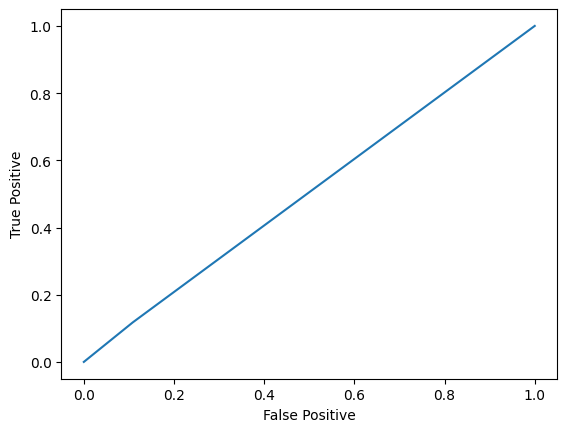

In [30]:
print(roc_auc_score(y_test, y_preds))
fpr, tpr, _ = roc_curve(y_test, y_preds)

plt.plot(fpr, tpr)
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show()

Таким образом, итоговый классификатор не очень хорошо позволяет классифицировать тексты на английском языке в соответствии с наличием в них признаков психологических проблем. В то время как тексты без подобных паттернов он определяет относительно неплохо, с показателем F1-меры в 0.65, тексты с их наличием классификатор распознает довольно плохо, об этом говорит F1-мера в 0.19.